# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

# The above is the code resources of this project. Adjustment are made to simplify the results and decrease computation time.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

## Imports

In [15]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
import pyarrow.parquet as pq
from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [16]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [17]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 96

TARGET_DATASET = "demand"
dataset_path = "data/demand.parquet"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [18]:
# Dataset
TARGET_DATASET = "demand"
dataset_path = "data/merged_data.csv"
timestamp_column = "timestamp"
id_columns = ["unique_id"]  # mention the ids that uniquely identify a time-series.

target_columns = ["y"]
split_config = {
    "train": [0, 10000],
    "valid": [10000, 11000],
    "test": [
        11000,
        12000,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
#data=pq.read_table('data/demand.parquet')
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

In [19]:
min(data["y"])

0.0203

## Zero-shot evaluation method

In [20]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[42, 57],
        channel=0,
    )

# Zeroshot

INFO:p-6263:t-7920442432:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-6263:t-7920442432:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-6263:t-7920442432:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.2876964807510376, 'eval_model_preparation_time': 0.0008, 'eval_runtime': 1.3179, 'eval_samples_per_second': 3433.584, 'eval_steps_per_second': 53.875}
(4525, 96, 1)
(4525, 1, 8, 192)


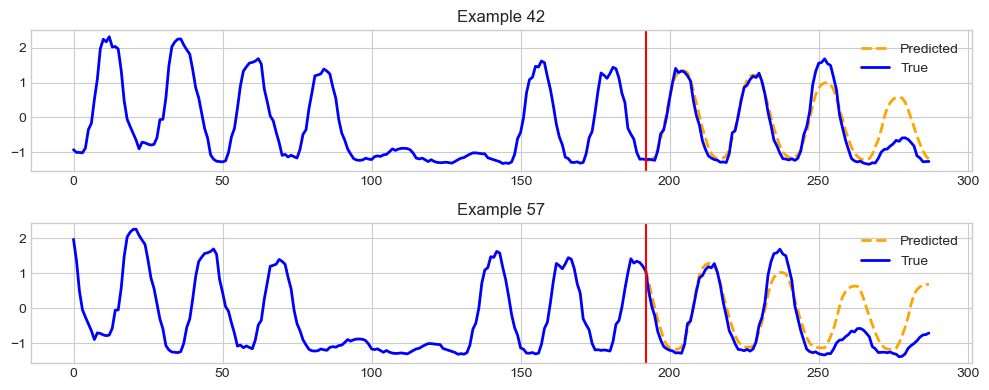

In [21]:
zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [22]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=15,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[118, 42, 57],
        channel=0,
    )

### Few-shot 5%

INFO:p-6263:t-7920442432:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-6263:t-7920442432:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-6263:t-7920442432:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


INFO:p-16191:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16191:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16197:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16197:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16199:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

Epoch,Training Loss,Validation Loss
1,0.257200,0.317709
2,0.183300,0.280188
3,0.142100,0.268678
4,0.108700,0.268577
5,0.089900,0.263868
6,0.078700,0.280413
7,0.073900,0.265167
8,0.069000,0.277813
9,0.065700,0.273408
10,0.064000,0.267466


INFO:p-16234:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16234:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16239:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16239:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16241:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-16350:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16350:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16352:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16352:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16354:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-16490:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16490:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16495:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16495:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16505:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-16701:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16701:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16705:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16705:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16762:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-16952:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16952:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16963:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-16963:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-16965:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-17162:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17162:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17164:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17164:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17166:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-17305:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17305:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17307:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17307:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17311:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-17446:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17446:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17448:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17448:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17506:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-17720:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17720:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17722:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17722:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17729:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-17919:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17919:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17921:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-17921:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-17924:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-18016:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18016:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18025:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18025:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18027:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-18177:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18177:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18179:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18179:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18239:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-18423:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18423:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18427:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18427:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18429:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

[TrackingCallback] Mean Epoch Time = 137.48294870058695 seconds, Total Train Time = 4178.704591751099
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


INFO:p-18587:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18587:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18589:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18589:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18595:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

{'eval_loss': 0.3312205374240875, 'eval_runtime': 71.9374, 'eval_samples_per_second': 62.902, 'eval_steps_per_second': 0.987, 'epoch': 15.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


INFO:p-18628:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18628:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18634:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18634:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18636:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

(4525, 96, 1)
(4525, 1, 8, 192)


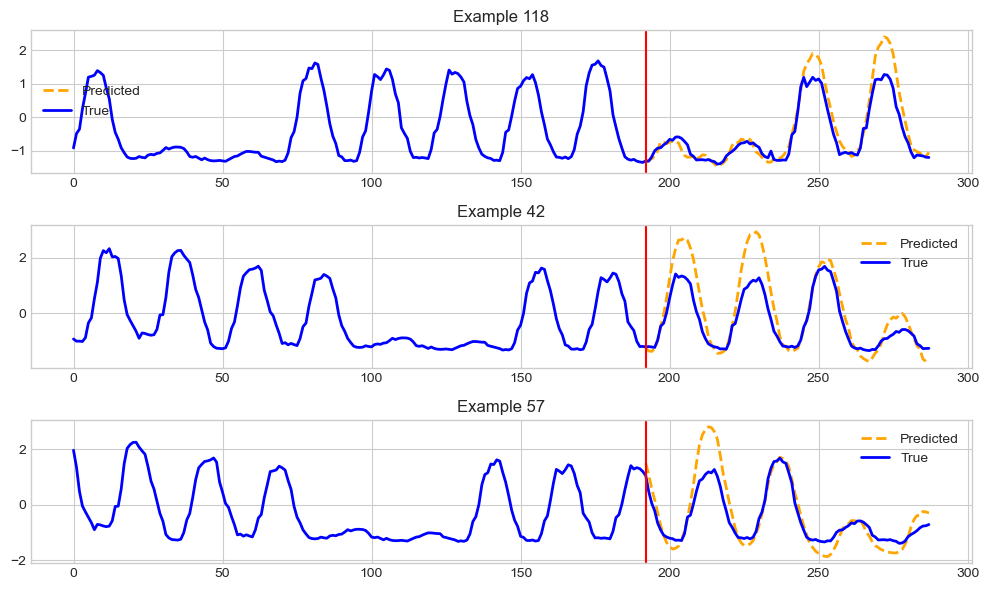

In [23]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

### Zero-shot

INFO:p-6263:t-7920442432:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-6263:t-7920442432:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-6263:t-7920442432:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.2818213105201721, 'eval_model_preparation_time': 0.0008, 'eval_runtime': 0.9788, 'eval_samples_per_second': 4622.919, 'eval_steps_per_second': 72.536}
(4525, 96, 1)
(4525, 1, 12, 384)


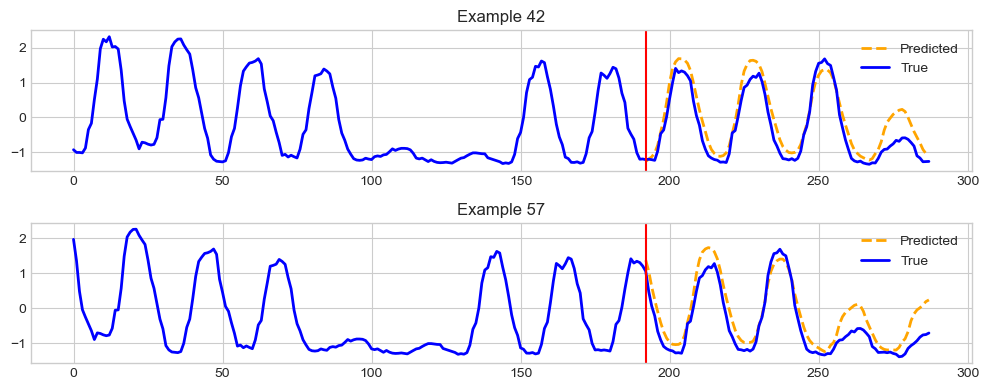

In [25]:
zeroshot_eval(dataset_name="demand2", context_length=1536, forecast_length=96, batch_size=64)

### Few-shot 5%

INFO:p-6263:t-7920442432:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 5% --------------------


INFO:p-6263:t-7920442432:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = 1536-96-r2.
INFO:p-6263:t-7920442432:get_model.py:get_model:[TTM] context_length = 1536, prediction_length = 96


Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560
Using learning rate = 0.001


INFO:p-18813:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18813:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18816:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18816:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18820:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

Epoch,Training Loss,Validation Loss
1,0.095900,0.717276
2,0.048700,0.699775
3,0.034600,0.707298
4,0.028100,0.706270
5,0.023500,0.691867
6,0.019300,0.712356
7,0.018700,0.729229
8,0.016400,0.727653
9,0.014400,0.719617
10,0.013200,0.710639


INFO:p-18852:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18852:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18854:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-18854:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-18856:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-19051:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19051:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19058:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19058:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19062:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-19279:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19279:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19281:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19281:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19287:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-19523:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19523:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19527:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19527:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19591:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-19809:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19809:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19820:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-19820:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-19823:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-20003:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20003:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20006:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20006:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20014:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-20180:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20180:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20183:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20183:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20190:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-20413:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20413:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20415:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20415:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20453:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-20584:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20584:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20588:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20588:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20591:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-20725:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20725:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20730:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20730:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20734:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-20949:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20949:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20961:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-20961:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-20967:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-21104:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21104:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21107:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21107:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21197:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

INFO:p-21319:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21319:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21322:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21322:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21330:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

[TrackingCallback] Mean Epoch Time = 879.4533337116242 seconds, Total Train Time = 25638.96697497368
++++++++++++++++++++ Test MSE after few-shot 5% fine-tuning ++++++++++++++++++++


INFO:p-21499:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21499:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21501:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21501:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21507:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

{'eval_loss': 0.5120124816894531, 'eval_runtime': 72.6688, 'eval_samples_per_second': 62.269, 'eval_steps_per_second': 0.977, 'epoch': 15.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


INFO:p-21612:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21612:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21618:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:p-21618:t-7920442432:utils.py:_init_num_threads:NumExpr defaulting to 8 threads.
/Users/wusiyuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
INFO:p-21620:t-7920442432:utils.py:_init_num_threads:Note: NumExpr detected 11

(4525, 96, 1)
(4525, 1, 12, 384)


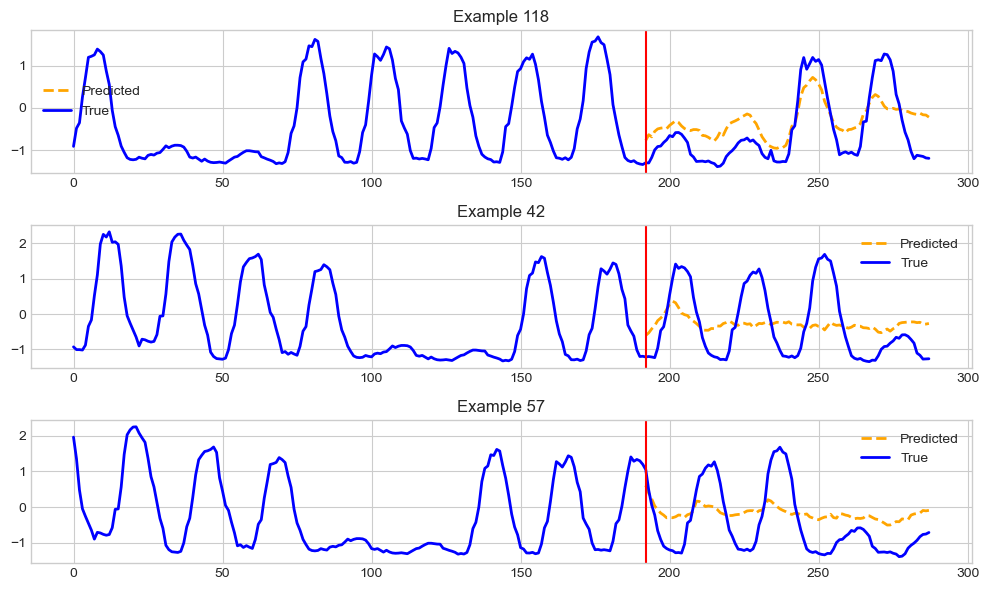

In [24]:
fewshot_finetune_eval(
    dataset_name="demand2",
    context_length=1536,
    forecast_length=96,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)